In [1]:
'''
The clean_photometry.py script uses supervised classification techniques 
to identify stars from noisy astronomical catalogs containing stars,
galaxies and noise from many different sources. 

With all dependencies installed (python3, scikit-learn, Pandas, NumPy, 
SciPy, AstroPy, Matplotlib, graphviz etc.) the simplest use case is:

./clean_photomtry.py $path/filename.phot

where filename.phot is the raw DOLPHOT photomtery output. 

This tool is built as part of the WFIRST simulations, analysis and 
recommendation pipeline for carrying out Nearby Galaxies projects. 
The current implementation requires STIPS simulation input catalogs
and  optionally uses STIPS simulated images.

- Rubab Khan
rubab@uw.edu

'''

import time, argparse, graphviz, matplotlib

#matplotlib.use('Agg')
from matplotlib import cm
from matplotlib import pyplot as plt
#plt.ioff()

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier as SGDc
from sklearn.neural_network import MLPClassifier as MLPc

from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from os import cpu_count
from scipy.spatial import cKDTree
from astropy.io import ascii, fits
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord, match_coordinates_sky

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
These parameters are used throughout the code:

feature_names: DOLPHOT quality parameters to use for 
training Machine Learning models. 

filters: WFIRST filters used in the simulation.

AB_Vega: Offsets between AB and Vega magnitude systems

fits_files, ref_fits, use_radec: Simulated images may 
be misaligned by design to emulate real observational
conditions.

'''

#feature_names=['err',Count','SNR','Sharpness','Roundness','Crowding']
feature_names=['err','SNR','Sharpness','Crowding']

# filter names
filters    = np.array(['Z087','Y106','J129','H158','F184'])
#filters    = np.array(['Z087','H158'])

# AB magnitude Zero points
AB_Vega    = np.array([0.487,  0.653, 0.958, 1.287, 1.552])
#AB_Vega    = np.array([0.487, 1.287])


# Simulated images
fits_files = ["sim_1_0.fits","sim_2_0.fits","sim_3_0.fits",
              "sim_4_0.fits","sim_5_0.fits"]

#fits_files = ["sim_1_0.fits","sim_4_0.fits"]

sky_coord  = np.zeros(len(filters))
ref_fits   = int(3)
use_radec  = False

In [3]:
def clean_all(filename='10_10_phot.txt',
          feature_names=feature_names,
          filters=filters,
          AB_Vega=AB_Vega,
          fits_files=fits_files,
          ref_fits=ref_fits,
          sky_coord=sky_coord,
          tol=2,test_size=0.1,valid_mag=30,
          use_radec=use_radec,
          show_plot=False,
          opt={'evaluate':True,
               'summary':True,
               'plots':True,
               'tree':False,
               'saveClean':True}):
    '''
    Top level wrapper to read data, clean data, train/test/evaluate
    classification model, make figure and display evaluation report
    
    Calls read_data(), prep_data(), classify() and makePlots().
    '''
    
    fileroot,filename = get_fileroot(filename)

    if use_radec:
        sky_coord = [wcs.WCS(fits.open(fileroot+imfile)[1].header) \
              for imfile in fits_files]
    
    input_data,output_data  = read_data(filename=filename,
                                        fileroot=fileroot,
                                        filters=filters)

    in_DF,out_DF,out_LAB    = prep_data(input_data,output_data,
                                        use_radec=use_radec,
                                        sky_coord=sky_coord,
                                        filters=filters,
                                        tol=tol,
                                        valid_mag=valid_mag,
                                        ref_fits=ref_fits)

    clf = MLPc(hidden_layer_sizes=(10,10,10),
               activation='logistic',
               solver='lbfgs',
               max_iter=20000,
               shuffle=True,
               warm_start=False,
               early_stopping=True,
               n_iter_no_change=10)

    new_labels = classify(out_DF,out_LAB,
                          filters=filters,
                          feature_names=feature_names,
                          test_size=test_size,
                          fileroot=fileroot,
                          opt=opt,
                          clf=clf)
    
    if opt['plots']: makePlots(in_DF,out_DF,new_labels,
                               sky_coord=sky_coord,
                               filters=filters,
                               fileroot=fileroot,
                               tol=tol,
                               use_radec=use_radec,
                               ref_fits=ref_fits,
                               show_plot=show_plot)
        
    if opt['saveClean']: saveCats(input_data,output_data,
                                  out_DF,new_labels,
                                  sky_coord=sky_coord,
                                  filters=filters,
                                  fileroot=fileroot,
                                  tol=tol,
                                  use_radec=use_radec,
                                  ref_fits=ref_fits,
                                  valid_mag=valid_mag)
    
    return print('\n')


def classify(out_DF,out_LAB,
             filters=filters,
             feature_names=feature_names,
             test_size=0.9,
             fileroot='',
             opt={'evaluate':True,
                  'summary':True,
                  'tree':True},
             clf = DecisionTreeClassifier()):
    '''
    High level wrapper to build and evaluate classification models
    for all bands and return new labels for the entire dataset.
    
    For each filter:
    - Extract features and label
    - Split into training and testing dataset
    - Train models, predict label for test set
    - optional: evaluate model performance, make figures,
                save the 'tree', and display report
    - Re-label the entire dataset: for qualitative evaluation 
    
    return an array containing new labels in each filter
    '''

    new_labels = []
    
    for i,filt in enumerate(filters):
        features = out_DF[i][feature_names]
        labels   = out_LAB[i]
        
        train_F,test_F,train_L,test_L = train_test_split(features,labels,
                                                         test_size=test_size)
        clf.fit(train_F,train_L)
        pred_L = clf.predict(test_F)
        
        if (opt['evaluate']|opt['summary']):
            print_report(filt,test_L,pred_L,feature_names,
                         opt['summary'])
            
        if opt['tree']:
            dot_data = export_graphviz(clf, out_file=None,
                                       leaves_parallel=True,
                                       feature_names=feature_names,
                                       class_names=['other','point'],
                                       max_depth=3)
            graph = graphviz.Source(dot_data)
            graph.render(fileroot+filt+'_tree')
            
        new_labels.append(clf.predict(features))
        
    return new_labels


def read_data(filename='10_10_phot.txt',fileroot='',filters=filters):
    '''
    Read in the raw fata files:
    - Input: sythetic photometry file for image generation, IPAC format
    - Output: DOLPHOT measured raw photometry, ASCII format
    
    Return arrays of AstroPy tables for input and numpy arrays for output
    ordered by corresponding filternames.
    '''
    input_data = [ascii.read(fileroot+filt+'_stips.txt',format='ipac')
                  for filt in filters]
    output_data  = np.loadtxt(fileroot+filename)
    np.random.shuffle(output_data)
    return input_data,output_data


def prep_data(input_data,output_data,sky_coord=sky_coord,
              filters=filters,use_radec=False,
              tol=2,valid_mag=30,ref_fits=0):
    '''
    Prepare the data for classification. The output data is now cleaned 
    to exclude low information entries and also labeled based on location 
    of detection.

    Return 3 arrays ordered by corresponding filternames:
    - First array for input data in pandas data frames
    - Second array for cleaned output data in pandas data frames
    - Third array for labels of output data in numpy arrays
    '''
    nfilt = filters.size
    xy         = output_data[:,2:4].T
    Count      = output_data[:,range(13,13+13*nfilt,13)].T
    vega_mags  = output_data[:,range(15,15+13*nfilt,13)].T
    mag_errors = output_data[:,range(17,17+13*nfilt,13)].T
    SNR        = output_data[:,range(19,19+13*nfilt,13)].T
    Sharp      = output_data[:,range(20,20+13*nfilt,13)].T
    Round      = output_data[:,range(21,21+13*nfilt,13)].T
    Crowd      = output_data[:,range(22,22+13*nfilt,13)].T    
    
    in_df,out_df,labels = [],[],[]
    
    for i in range(nfilt):
        in_df.append(pack_input(input_data[i],valid_mag=valid_mag))
        
        t = validate_output(mag_errors[i],
                            Count[i],SNR[i],
                            Sharp[i],Round[i],
                            Crowd[i])
        
        out_df.append(pack_output(xy,vega_mags[i],mag_errors[i],
                                  Count[i],SNR[i],Sharp[i],Round[i],
                                  Crowd[i],t))

        labels.append(label_output(in_df[i],out_df[i],
                                   tol=tol,
                                   valid_mag=valid_mag,
                                   radec={'opt':use_radec,
                                          'wcs1':sky_coord[i],
                                          'wcs2':sky_coord[ref_fits]}))
        
    return in_df,out_df,labels


def validate_output(err,count,snr,shr,rnd,crd):
    '''
    Clean and validate output data
    - Remove measurements with unphysical values, such as negative countrate
    - Remove low information entries, such as magnitude errors >0.5 & SNR <1
    - Remove missing value indicators such as +/- 9.99
    '''
    return (err<0.5)&(count>=0)&(snr>=1)&(crd!=9.999)&\
        (shr!=9.999)&(shr!=-9.999)&(rnd!=9.999)&(rnd!=-9.999)

def scale_features(_df):
    scaler = StandardScaler()
    for i,df in enumerate(_df):
        df['err'] = scaler.fit_transform(df['err'].values.reshape(-1, 1))
        df['Count'] = scaler.fit_transform(df['Count'].values.reshape(-1, 1))
        df['SNR'] = scaler.fit_transform(df['SNR'].values.reshape(-1, 1))
        df['Crowding'] = scaler.fit_transform(df['Crowding'].values.reshape(-1, 1))
        df['Sharpness'] = scaler.fit_transform(df['Sharpness'].values.reshape(-1, 1))
        df['Roundness'] = scaler.fit_transform(df['Roundness'].values.reshape(-1, 1))
        _df[i] = df
    return _df

def pack_input(data,valid_mag=30):
    '''
    return Pandas Dataframes for input AstroPy tables containing 
    sources that are brighter than specified magnitude (valid_mag)
    '''
    t = data['vegamag'] < valid_mag
    return pd.DataFrame({'x':data['x'][t],'y':data['y'][t],\
                         'm':data['vegamag'][t],'type':data['type'][t]})


def pack_output(xy,mags,errs,count,snr,shr,rnd,crd,t):
    '''
    return Pandas Dataframes for output numpy arrays including
    all quality parameter
    '''
    return pd.DataFrame({'x':xy[0][t],'y':xy[1][t],'mag':mags[t],'err':errs[t],
                        'Count':count[t],'SNR':snr[t],'Sharpness':shr[t],
                         'Roundness':rnd[t],'Crowding':crd[t]})
    #return _df.reindex(np.random.permutation(_df.index))


def label_output(in_df,out_df,tol=2,valid_mag=30,
                 radec={'opt':False,'wcs1':'','wcs2':''}):
    '''
    Label output data entries and return the labels as numpy array.
    
    Match each remaining output entry with the closest input entry 
    within matching radius specified by 'tol' that are brighter than 
    specified magnitude (valid_mag).
    
    Those matched to point source input are labeled '1', 
    everything else get '0' label.
    
    Optionally, use sky_soordinates from the simulated images since 
    the images may not be aligned to each other. 
    '''
    X,Y = in_df['x'].values,in_df['y'].values
    typ_in = in_df['type'].values
    mags = in_df['m'].values
    t = (mags<valid_mag)
    X,Y,typ_in = X[t],Y[t],typ_in[t]
    x,y = out_df['x'].values,out_df['y'].values
    tmp, typ_out = match_in_out(tol,X,Y,x,y,typ_in,radec=radec)
    typ_out[typ_out=='sersic'] = 'other'
    magDiff = np.zeros(len(X))
    magDiff[tmp!=-1] = in_df['m'].values[tmp!=-1]-out_df['mag'].values[tmp[tmp!=-1]]
    #print(len(typ_out[tmp[tmp!=-1]][np.fabs(magDiff[tmp!=-1])>0.5]=='point'))
    typ_out[tmp[tmp!=-1]][np.fabs(magDiff[tmp!=-1])>0.5] = 'other'
    typ_bin = label_binarize(typ_out,classes=['other','point'])
    typ_bin = typ_bin.reshape((typ_bin.shape[0],))
    return typ_bin


def input_pair(df,i,j,radec={'opt':False,'wcs1':'','wcs2':''}):
    '''
    Pick sources added in both bands as same object types
    
    return data dictionary containing the two input magnitudes 
    (m1_in, m2_in), coordinates (X, Y) and input source type
    (typ_in)
    '''
    m1_in,m2_in,X1,Y1,X2,Y2 = df[i]['m'].values,df[j+1]['m'].values,\
        df[i]['x'].values,df[i]['y'].values,\
        df[j+1]['x'].values,df[j+1]['y'].values
    typ1_in, typ2_in = df[i]['type'].values, df[j+1]['type'].values

    if radec['opt']:
        ra1,dec1 = xy_to_wcs(np.array([X1,Y1]).T,radec['wcs1'])
        ra2,dec2 = xy_to_wcs(np.array([X2,Y2]).T,radec['wcs2'])
        in12= matchCats(0.05,ra1,dec1,ra2,dec2)
    else:
        in12 = matchLists(0.1,X1,Y1,X2,Y2)

    m1_in,X1,Y1,typ1_in = m1_in[in12!=-1],\
        X1[in12!=-1],Y1[in12!=-1],typ1_in[in12!=-1]
    in12 = in12[in12!=-1]
    m2_in,typ2_in = m2_in[in12],typ2_in[in12]
    
    tt = typ1_in==typ2_in
    m1_in,m2_in,X,Y,typ_in = m1_in[tt],\
        m2_in[tt],X1[tt],Y1[tt],typ1_in[tt]
    return dict(zip(['m1_in','m2_in','X','Y','typ_in'],[m1_in,m2_in,X,Y,typ_in]))


'''Recovered source photometry and quality params'''
def output_pair(df,labels,i,j):
    '''
    Pick sources detected in both bands as same object types
    
    return data dictionary containing the two output magnitudes (mag) 
    coordinates (xy), all quality parameters (err,snr,crd,rnd,shr)
    and labels (lbl). Each dictionary item is has two elements for 
    two filters (xy has x and y).
    '''
    X1,Y1,X2,Y2 = df[i]['x'].values,df[i]['y'].values,\
                  df[j+1]['x'].values,df[j+1]['y'].values
    t2 = matchLists(0.1,X1,Y1,X2,Y2)
    t1 = t2!=-1
    t2 = t2[t2!=-1] 
    xy = X1[t1],Y1[t1]
    mags = [df[i]['mag'][t1].values,df[j+1]['mag'][t2].values]
    errs = [df[i]['err'][t1].values,df[j+1]['err'][t2].values]
    snrs = [df[i]['SNR'][t1].values,df[j+1]['SNR'][t2].values]
    crds = [df[i]['Crowding'][t1].values,df[j+1]['Crowding'][t2].values]
    rnds = [df[i]['Roundness'][t1].values,df[j+1]['Roundness'][t2].values]
    shrs = [df[i]['Sharpness'][t1].values,df[j+1]['Sharpness'][t2].values]
    lbls = [labels[i][t1],labels[j+1][t2]]
    nms = ['xy','mag','err','snr','crd','rnd','shr','lbl']
    K = [xy,mags,errs,snrs,crds,rnds,shrs,lbls]
    return dict(zip(nms,K))


def clean_pair(inPair,outPair,tol=2,radec={'opt':False,'wcs1':'','wcs2':''}):
    '''
    Re-classify sources detected in both bands as stars. Change detected 
    source type from 'star' to 'other' if their location do not match to
    that of a star added in both bands as stars
    
    return data dictionary containing the two output magnitudes 
    (m1, m2), coordinates (X, Y) and output source type (typ_out)
    '''
    X1,Y1,typ_in = inPair['X'],inPair['Y'],inPair['typ_in']
    X2,Y2 = outPair['xy'][0],outPair['xy'][1]
    m1_out,m2_out = outPair['mag'][0],outPair['mag'][1]
    t1,t2 = outPair['lbl'][0],outPair['lbl'][1]
    t = (t1==1)&(t2==1)
    X2,Y2,m1_out,m2_out = X2[t],Y2[t],m1_out[t],m2_out[t]
    tmp, typ_out = match_in_out(tol,X1,Y1,X2,Y2,typ_in,radec=radec)
    clean_pair = dict(zip(['m1','m2','x','y','typ_out'],
                          [m1_out,m2_out,X2,Y2,typ_out]))
    return clean_pair

def saveCats(inDAT,outDAT,outDF,Labels,
             sky_coord=sky_coord,fileroot='',
             filters=filters,tol=2,ref_fits=0,
             use_radec=False,valid_mag=30):
    i = -1
    flags = []
    _X,_Y = outDAT[:,2].T, outDAT[:,3].T
    
    for data,df,label,filt in zip(inDAT,outDF,Labels,filters):
        i += 1
        t = data['vegamag'] < valid_mag
        _df1 = pd.DataFrame({'x':data['x'],'y':data['y'],'mag':data['vegamag']})
        _df2 = df[label==1]
        
        X,Y = _df1['x'].values,_df1['y'].values
        x,y = _df2['x'].values,_df2['y'].values  
        if use_radec:
            ra1,dec1 = xy_to_wcs(np.array([X,Y]).T,sky_coord[i])
            ra2,dec2 = xy_to_wcs(np.array([x,y]).T,sky_coord[ref_fits])
            in1 = matchCats(tol*0.11,ra1,dec1,ra2,dec2)
            in2 = matchCats(tol*0.11,ra2,dec2,ra1[t],dec1[t])
        else:
            in1 = matchLists(tol,X,Y,x,y)
            in2 = matchLists(tol,x,y,X[t],Y[t])
            
        # Extend input list with recovered mag
        remag = np.repeat(99.99,len(X))
        reX = np.repeat(99.99,len(X))
        reY = np.repeat(99.99,len(X))
        _t = (in1!=-1)&t
        remag[_t] = _df2['mag'].values[in1[_t]]
        reX[_t] = x[in1[_t]] 
        reY[_t] = y[in1[_t]] 
        data['recovmag'] = remag
        data['recov_x'] = reX
        data['recov_y'] = reY
        ascii.write(data,fileroot+str(filt)+'_recov_input.txt',format='ipac')

        # Extend output list with input mag
        inmag = np.repeat(99.99,len(x))
        _t = in2!=-1
        inmag[_t] = _df1['mag'].values[t][in2[_t]]
        _df2['inputmag'] = inmag
        _df2[['x','y','mag','err','inputmag','Count','Crowding','Roundness','SNR',
             'Sharpness']].to_csv(fileroot+str(filt)+'_clean.csv',index=False)
        
        # Make shorter recovered phot file keeping sources kept in at least one filter
        in1 = matchLists(0.1,_X,_Y,x,y)
        flag = np.zeros(len(_X))
        flag[in1!=-1] = 1         
        flags.append(flag)
        
    flag = np.sum(flags,axis=0)
    idx = np.arange(len(flag))
    idx = idx[flag!=0]
    newDAT = outDAT[idx,:]
    return np.savetxt(fileroot+'Clean_Catalog.phot',newDAT,fmt='%10.7e')


def matchLists(tol,x1,y1,x2,y2):
    '''
    Match X and Y coordinates using cKDTree
    return index of 2nd list at coresponding position in the 1st 
    return -1 if no match is found within matching radius (tol)
    '''
    d1 = np.empty((x1.size, 2))
    d2 = np.empty((x2.size, 2))
    d1[:,0],d1[:,1] = x1,y1
    d2[:,0],d2[:,1] = x2,y2
    t = cKDTree(d2)
    tmp, in1 = t.query(d1, distance_upper_bound=tol)
    in1[in1==x2.size] = -1
    return in1


def matchCats(tol,ra1,dec1,ra2,dec2):
    '''
    Match astronomical coordinates using SkyCoord
    return index of 2nd list at coresponding position in the 1st 
    return -1 if no match is found within matching radius (tol)
    '''
    c1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    c2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    in1,sep,tmp = match_coordinates_sky(c1,c2,storekdtree=False)
    sep = sep.to(u.arcsec)
    in1[in1==ra2.size] = -1
    in1[sep>tol*u.arcsec] = -1
    return in1


def match_in_out(tol,X,Y,x,y,typ_in,
                 radec={'opt':False,'wcs1':'','wcs2':''}):
    '''
    Match input coordnates to recovered coordinates picking the 
    closest matched item.
    
    return index of output entry at coresponding position in the 
    input list and source type of the matching input
    
    return -1 as the index if no match is found and source type 
    as 'other' (not point source)
    '''
    if radec['opt']:
        ra1,dec1 = xy_to_wcs(np.array([X,Y]).T,radec['wcs1'])
        ra2,dec2 = xy_to_wcs(np.array([x,y]).T,radec['wcs2'])
        in1 = matchCats(tol*0.11,ra1,dec1,ra2,dec2)
    else:
        in1 = matchLists(tol,X,Y,x,y)

    in2 = in1!=-1
    in3 = in1[in2]
    in4 = np.arange(len(x))
    in5 = np.setdiff1d(in4,in3)
    typ_out = np.empty(len(x),dtype='<U10')
    typ_out[in3] = typ_in[in2]
    typ_out[in5] = 'other'
    return in1, typ_out


def print_report(filt,test_labels,pred_labels,feat_nms,feat_imp=[],short_rep=True):
    '''
    Evaluate the classification model
    - Score the classifier for all classes and each class separately
    - Manually calculate Precision, Recall and Specficity 
    - Display the values along with feature importances
    '''
    
    score1 = accuracy_score(test_labels,pred_labels)
    score2 = accuracy_score(test_labels[test_labels==0],pred_labels[test_labels==0])
    score3 = accuracy_score(test_labels[test_labels==1],pred_labels[test_labels==1])
    tp = int(np.ceil(score3*len(test_labels[test_labels==1])))
    fn = int(np.ceil((1-score3)*len(test_labels[test_labels==1])))
    tn = int(np.ceil(score2*len(test_labels[test_labels==0])))
    fp = int(np.ceil((1-score2)*len(test_labels[test_labels==0])))
    print('\nBand {:s} feature importance:'.format(filt))
    if not short_rep:
        print('\n Non-point: {:d}'.format(len(test_labels[test_labels==0])))
        print(' Point:\t\t{:d}\n'.format(len(test_labels[test_labels==1])))
        print(' Tp:\t\t{:d}\n Fp:\t\t{:d}\n Tn:\t\t{:d}\n Fn:\t\t{:d}\n'.format(tp,fp,tn,fn))
        print(' All:\t\t{:.2f}\n Non-point:\t{:.2f}\n Point:\t\t{:.2f}\n'.format(score1,score2,score3))
        print(' Precision:\t{:.2f}'.format(tp/(tp+fp)))
    #_tmp = [print('{:s}:\t{:.3f}'.format(feat_nms[i],feat_imp[i]))
    #        for i in range(len(feat_nms))]
    print('\n Precision:\t{:.2f}'.format(tp/(tp+fp)))
    print(' Recall:\t{:.2f} (Sensitivity)'.format(tp/(tp+fn)))
    print(' Specificity:\t{:.2f}\n'.format(tn/(tn+fp)))    
    return print('\n')


def makePlots(in_DF,out_DF,new_labels,
              sky_coord=sky_coord,fileroot='',
              filters=filters,
              tol=5,ref_fits=0,
              use_radec=False,
              show_plot=False):
    '''
    Produce figures and text to qualitatively evaluate practicality 
    of the classification model for the intended use case of maximizing 
    star identification in realistic catalogs
    '''
    paired_in    = lambda a,b,c: input_pair(in_DF,a,b,c)
    paired_out   = lambda a,b: output_pair(out_DF,new_labels,a,b)

    for i in range(len(filters)-1):
        for j in range(i,len(filters)-1):
            radec1 = {'opt':use_radec,
                      'wcs1':sky_coord[i],'wcs2':sky_coord[j+1]}
            radec2 = {'opt':use_radec,
                      'wcs1':sky_coord[i],'wcs2':sky_coord[ref_fits]}
            inPair,outPair = paired_in(i,j,radec1),paired_out(i,j)
            clnPair = clean_pair(inPair,outPair,tol=tol,radec=radec2)
                                 
            make_plots(inPair,outPair,clnPair,\
                       fileroot=fileroot,tol=tol,\
                       filt1=filters[i],filt2=filters[j+1],\
                       AB_Vega1=AB_Vega[i],AB_Vega2=AB_Vega[j+1],\
                       opt=['input','output','clean','diff'],\
                       radec=radec2,show_plot=show_plot)
    return print('\n')


def make_plots(all_in=[],all_out=[],clean_out=[],\
               filt1='',filt2='',AB_Vega1=0,AB_Vega2=0,
               fileroot='',tol=5,
               opt=['input','output','clean','diff'],
               radec={'opt':False,'wcs1':'','wcs2':''},
               show_plot=False):
    '''Produce color-magnitude diagrams and systematic offsets'''
    print('\nFilters {:s} and {:s}:'.format(filt1,filt2))
    plot_me = lambda a,b,st,ot,ttl,pre,post: \
              plot_cmd(a,b,filt1=filt1,filt2=filt2,\
                       stars=st,other=ot,title=ttl,\
                       fileroot=fileroot,outfile=\
                       '_'.join((pre,'cmd',filt1,filt2,post)),\
                       show_plot=show_plot)
    plot_it = lambda a,b,filt: \
              plot_xy(x=a,y=a-b,\
                      ylim1=-1.5,ylim2=0.5,xlim1=24.5,xlim2=28,\
                      ylabel='magIn - magOut',xlabel='magOut',\
                      title='In-Out Mag Diff {:s}'.format(filt),\
                      fileroot=fileroot,\
                      outfile='_'.join(('mag','diff',filt)),\
                      show_plot=show_plot)

    if (('input' in opt)&(len(all_in)>0)):
        m1_in,m2_in,typ_in = all_in['m1_in'],all_in['m2_in'],all_in['typ_in']
        stars,other = typ_in=='point',typ_in!='point'
        print('Stars: {:d}  Others: {:d}'.format(int(np.sum(stars)),int(np.sum(other))))
        plot_me(m1_in,m2_in,stars,other,\
                'Input CMD (Vega)','input','Vega')

    if (('output' in opt)&(len(all_out)>0)):
        m1,m2 = all_out['mag'][0], all_out['mag'][1]
        if 'input' in opt:
            X,Y,x,y = all_in['X'],all_in['Y'], all_out['xy'][0], all_out['xy'][1]
            in1, typ_out = match_in_out(tol,X,Y,x,y,typ_in,radec=radec)
            stars,other = typ_out=='point',typ_out!='point'
            if (('diff' in opt)|('diff2' in opt)):
                t1 = (in1!=-1)&(typ_in=='point')
                m1in,m2in,m1t,m2t = m1_in[t1],m2_in[t1],m1[in1[t1]],m2[in1[t1]]
                t2 = typ_out[in1[t1]]=='point'
                m1in,m2in,m1t,m2t=m1in[t2],m2in[t2],m1t[t2],m2t[t2]
                if 'diff' in opt:
                    plot_it(m1in,m1t,filt1)
                if 'diff2' in opt:
                    plot_it(m2in,m2t,filt2)
        else:
            typ_out = np.repeat('other',len(m1))
        stars,other = typ_out=='point',typ_out!='point'
        print('Stars: {:d}  Others: {:d}'.format(int(np.sum(stars)),int(np.sum(other))))
        plot_me(m1,m2,stars,other,'Full CMD','output','full')

    if (('clean' in opt)&(len(clean_out)>0)):
        m1,m2,typ_out = clean_out['m1'],clean_out['m2'],clean_out['typ_out']
        stars,other = typ_out=='point',typ_out!='point'
        print('Stars: {:d}  Others: {:d}'.format(int(np.sum(stars)),int(np.sum(other))))
        plot_me(m1,m2,stars,other,'Cleaned CMD','clean','clean')        
        rr,fr = get_stat(all_in['typ_in'],clean_out['typ_out'])
        print('Recovery Rate:\t {:.2f}\nFalse Rate: \t {:.2f}\n'.format(rr,fr))
    return print('\n')


def plot_cmd(m1,m2,e1=[],e2=[],filt1='',filt2='',stars=[],other=[],\
             fileroot='',outfile='test',fmt='png',\
             xlim1=-1.5,xlim2=3.5,ylim1=29.5,ylim2=20.5,n=4,
             title='',show_plot=False):
    '''Produce color-magnitude diagrams'''
    m1m2 = m1-m2
    plt.rc("font", family='serif', weight='bold')
    plt.rc("xtick", labelsize=15); plt.rc("ytick", labelsize=15)
    fig = plt.figure(1, ((10,10)))
    fig.suptitle(title,fontsize=5*n)
    if len(stars[stars])==0:
        m1m2t,m2t = plotHess(m1m2,m2)
        plt.plot(m1m2t,m2t,'k.',markersize=2,alpha=0.75,zorder=3)
    else:
        plt.plot(m1m2[stars],m2[stars],'b.',markersize=2,\
            alpha=0.75,zorder=2,label='Stars: %d' % len(m2[stars]))
        plt.plot(m1m2[other],m2[other],'k.',markersize=1,\
            alpha=0.5,zorder=1,label='Other: %d' % len(m2[other]))
        plt.legend(loc=4,fontsize=20)
    if (len(e1)&len(e2)):
        m1m2err = np.sqrt(e1**2+e2**2)
        plot_error_bars(m2,e2,m1m2err,xlim1,xlim2,ylim1,slope=[])
    plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2)
    plt.xlabel(str(filt1+'-'+filt2),fontsize=20)
    plt.ylabel(filt2,fontsize=20)
    print('\t\t\t Writing out: ',fileroot+outfile+'.'+str(fmt))
    plt.savefig(fileroot+outfile+'.'+str(fmt))
    if show_plot: plt.show()
    return plt.close()


def plot_xy(x,y,xlabel='',ylabel='',title='',stars=[],other=[],\
            xlim1=-1,xlim2=1,ylim1=-7.5,ylim2=7.5,\
            fileroot='',outfile='test',fmt='png',n=4,
            show_plot=False):
    '''Custom scatterplot maker'''
    plt.rc("font", family='serif', weight='bold')
    plt.rc("xtick", labelsize=15); plt.rc("ytick", labelsize=15)
    fig = plt.figure(1, ((10,10)))
    fig.suptitle(title,fontsize=5*n)
    if not len(x[other]):
        plt.plot(x, y,'k.',markersize=1,alpha=0.5)
    else:
        plt.plot(x[stars],y[stars],'b.',markersize=2,\
            alpha=0.5,zorder=2,label='Stars: %d' % len(x[stars]))
        plt.plot(x[other],y[other],'k.',markersize=1,\
            alpha=0.75,zorder=1,label='Other: %d' % len(x[other]))
        plt.legend(loc=4,fontsize=20)
    plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.savefig(fileroot+outfile+'.'+str(fmt))
    #print('\t\t\t Writing out: ',fileroot+outfile+'.'+str(fmt))
    if show_plot: plt.show()
    return plt.close()


def plotHess(color,mag,binsize=0.1,threshold=25):
    '''Overplot hess diagram for densest regions 
    of a scatterplot'''
    if not len(color)>threshold:
        return color,mag
    mmin,mmax = np.amin(mag),np.amax(mag)
    cmin,cmax = np.amin(color),np.amax(color)
    nmbins = np.ceil((cmax-cmin)/binsize)
    ncbins = np.ceil((cmax-cmin)/binsize)
    Z, xedges, yedges = np.histogram2d(color,mag,\
                            bins=(ncbins,nmbins))
    X = 0.5*(xedges[:-1] + xedges[1:])
    Y = 0.5*(yedges[:-1] + yedges[1:])
    y, x = np.meshgrid(Y, X)
    z = np.ma.array(Z, mask=(Z==0))
    levels = np.logspace(np.log10(threshold),\
            np.log10(np.amax(z)),(nmbins/ncbins)*20)
    if (np.amax(z)>threshold)&(len(levels)>1):
        cntr=plt.contourf(x,y,z,cmap=cm.jet,levels=levels,zorder=0)
        cntr.cmap.set_under(alpha=0)
        x,y,z = x.flatten(),y.flatten(),Z.flatten()
        x = x[z>2.5*threshold]
        y = y[z>2.5*threshold]
        mask = np.zeros_like(mag)
        for col,m in zip(x,y):
            mask[(m-binsize<mag)&(m+binsize>mag)&\
                 (col-binsize<color)&(col+binsize>color)]=1
            mag = np.ma.array(mag,mask=mask)
            color = np.ma.array(color,mask=mask)
    return color,mag


def xy_to_wcs(xy,_w):
    '''Convert pixel coordinates (xy) to astronomical
    coordinated (RA and DEC)'''
    _radec = _w.wcs_pix2world(xy,1)
    return _radec[:,0],_radec[:,1]


def get_stat(typ_in,typ_out):
    ''' Return recovery rate and false rate for stars'''
    all_in, all_recov = len(typ_in), len(typ_out)
    stars_in = len(typ_in[typ_in=='point'])
    stars_recov = len(typ_out[typ_out=='point'])
    recovery_rate = (stars_recov / stars_in)
    false_rate = 1 - (stars_recov / all_recov)
    return recovery_rate,false_rate


def get_fileroot(filename):
    '''return path to a file and filename'''
    if '/' in filename:
        tmp = filename.split('/')[-1]
        fileroot = filename[:-len(tmp)]
        filename = tmp
    else:
        fileroot = ''
    return fileroot, filename


def parse_all():
    '''Argument parser for command line use'''
    parser = argparse.ArgumentParser()
    parser.add_argument('filenames', nargs='+',help='Photomtery file names')
    parser.add_argument('--RADIUS', '-tol', type=float, dest='tol', default=5, help='Matching radius in pixels')
    parser.add_argument('--TESTSIZE', '-test', type=float, dest='test', default=0.75, help='Test sample size')
    parser.add_argument('--VALIDMAG', '-mag', type=float, dest='mag', default=30, help='Expected depth in mag')
    return parser.parse_args()

In [4]:
# Read all data
input_data,output_data  = read_data(filename='10_10_phot.txt',
                                    filters=filters)

In [5]:
# Clean, format and label data
in_DF,out_DF,out_LAB    = prep_data(input_data,output_data)
out_df2 = scale_features(out_DF)

In [6]:
clf = MLPc(hidden_layer_sizes=(10,10,10),
           activation='logistic',
           solver='lbfgs',
           #alpha=0.0001,
           #batch_size='auto',
           #learning_rate='adaptive',
           #learning_rate_init=0.0005,
           #power_t=0.5,
           max_iter=20000, #watch
           shuffle=True,
           #random_state=None,
           #tol=1e-3,
           #verbose=False,
           warm_start=False,
           #momentum=0.9,
           #nesterovs_momentum=True,
           early_stopping=True,
           #validation_fraction=0.1,
           #beta_1=0.9, beta_2=0.999,
           #epsilon=0.1,
           n_iter_no_change=10)

In [7]:
# Example for 1 filter

# Extract features and label
features = out_df2[0][feature_names]
labels   = out_LAB[0]
filt = filters[0]

# Split into training and testing datasets
train_F,test_F,train_L,test_L = train_test_split(features,labels,test_size=0.1)

# Train and predict
clf.fit(train_F,train_L)
pred_L = clf.predict(test_F)

# Evaluate the model
print_report(filt,test_L,pred_L,feature_names)


Band Z087 feature importance:

 Precision:	0.83
 Recall:	0.74 (Sensitivity)
 Specificity:	0.92





In [8]:
# Relabel the data for qualitative evaluation
_new_labels = clf.predict(features)

In [9]:
# For all filters
new_labels = classify(out_DF,out_LAB,
                      clf=clf,
                      test_size=0.75,
                      opt={'evaluate':False,
                           'summary':True,
                           'tree':False})


Band Z087 feature importance:

 Precision:	0.82
 Recall:	0.74 (Sensitivity)
 Specificity:	0.92




Band Y106 feature importance:

 Precision:	0.84
 Recall:	0.76 (Sensitivity)
 Specificity:	0.92




Band J129 feature importance:

 Precision:	0.83
 Recall:	0.74 (Sensitivity)
 Specificity:	0.93




Band H158 feature importance:

 Precision:	0.82
 Recall:	0.69 (Sensitivity)
 Specificity:	0.93




Band F184 feature importance:

 Precision:	0.72
 Recall:	0.47 (Sensitivity)
 Specificity:	0.93






Filters Z087 and Y106:
Stars: 49578  Others: 11304
			 Writing out:  input_cmd_Z087_Y106_Vega.png


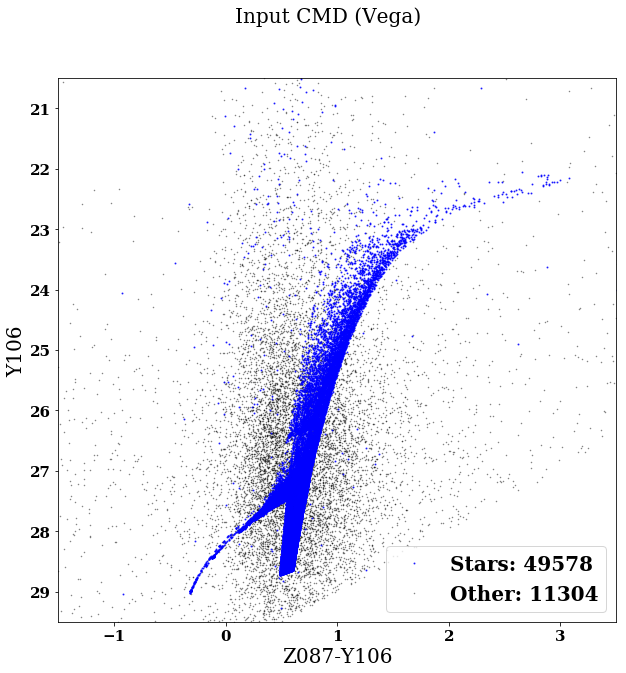

Stars: 37467  Others: 28068
			 Writing out:  output_cmd_Z087_Y106_full.png


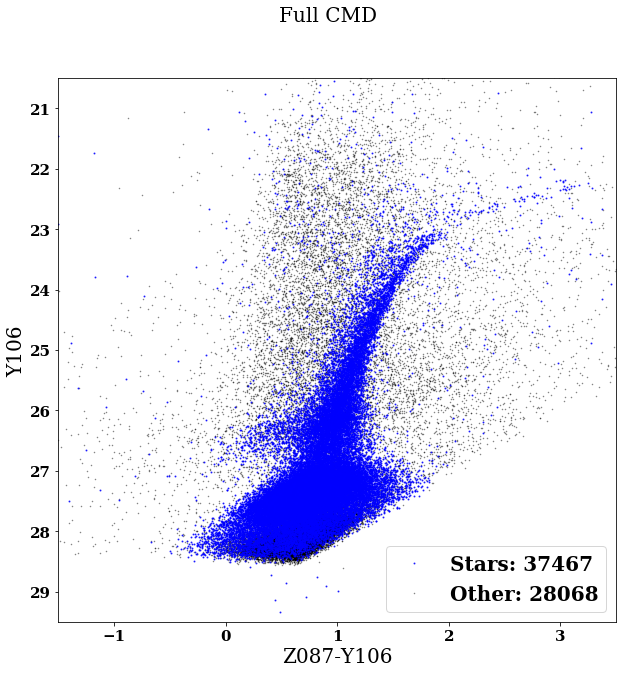

In [10]:
# Make figures for qualitative evaluation
# Example for one pair of filters

# Properly added in both filters
inPair   = input_pair(in_DF,0,1)

# Properly detected in both filters
outPair  = output_pair(out_DF,new_labels,0,1)

# Added and detected in both filters
clnPair  = clean_pair(inPair,outPair)

# Show input and output data
make_plots(inPair,outPair,clnPair,\
           filt1=filters[0],filt2=filters[1],\
           opt=['input','output'],show_plot=True)


Filters Z087 and Y106:
Stars: 25444  Others: 2857
			 Writing out:  clean_cmd_Z087_Y106_clean.png


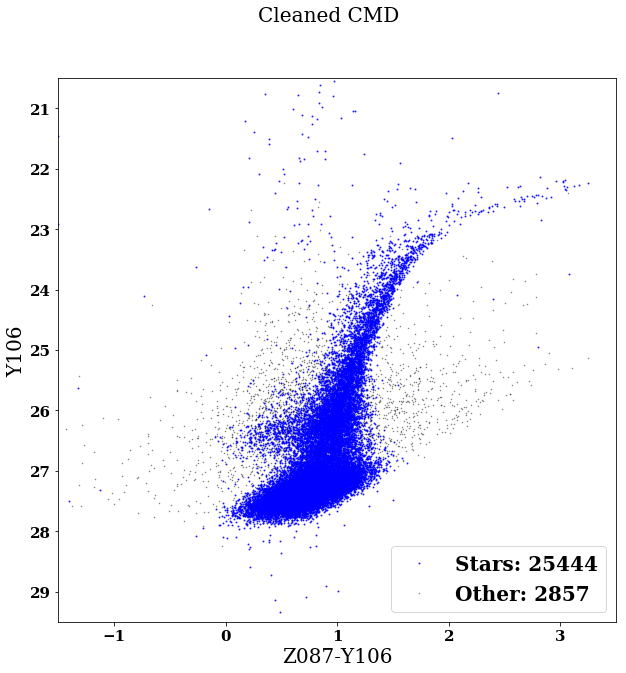

Recovery Rate:	 0.51
False Rate: 	 0.10





In [11]:
# Show re-labeled data, for qualitative evaluation
make_plots(inPair,outPair,clnPair,\
           filt1=filters[0],filt2=filters[1],\
           opt=['clean'],show_plot=True)

In [12]:
# Qualitative evaluation, for all filter pairs
makePlots(in_DF,out_DF,new_labels,show_plot=False)


Filters Z087 and Y106:
Stars: 49578  Others: 11271
			 Writing out:  input_cmd_Z087_Y106_Vega.png
Stars: 37703  Others: 27926
			 Writing out:  output_cmd_Z087_Y106_full.png
Stars: 25613  Others: 3685
			 Writing out:  clean_cmd_Z087_Y106_clean.png
Recovery Rate:	 0.52
False Rate: 	 0.13




Filters Z087 and J129:
Stars: 49578  Others: 11304
			 Writing out:  input_cmd_Z087_J129_Vega.png
Stars: 37467  Others: 28068
			 Writing out:  output_cmd_Z087_J129_full.png
Stars: 24946  Others: 3355
			 Writing out:  clean_cmd_Z087_J129_clean.png
Recovery Rate:	 0.50
False Rate: 	 0.12




Filters Z087 and H158:
Stars: 49579  Others: 11320
			 Writing out:  input_cmd_Z087_H158_Vega.png
Stars: 36749  Others: 28669
			 Writing out:  output_cmd_Z087_H158_full.png
Stars: 22822  Others: 2788
			 Writing out:  clean_cmd_Z087_H158_clean.png
Recovery Rate:	 0.46
False Rate: 	 0.11




Filters Z087 and F184:
Stars: 49579  Others: 11341
			 Writing out:  input_cmd_Z087_F184_Vega.png
Stars: 31665  Others: 


Filters Z087 and Y106:
Stars: 49578  Others: 11271
			 Writing out:  input_cmd_Z087_Y106_Vega.png


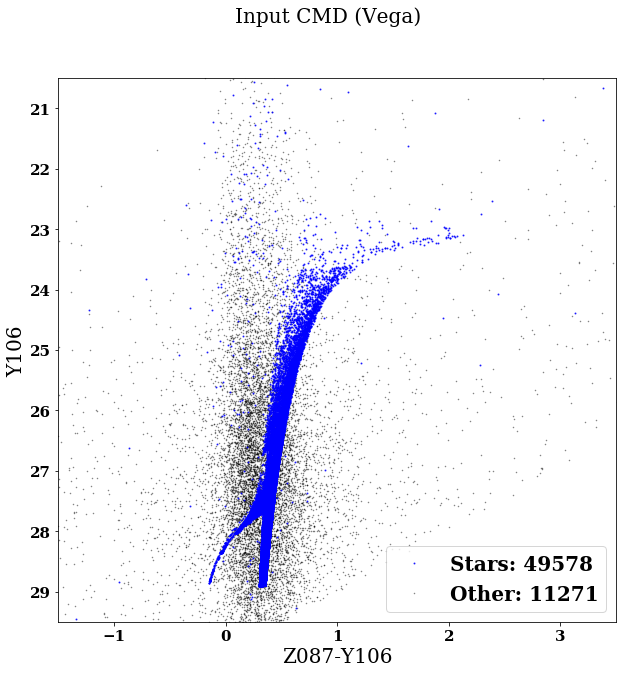

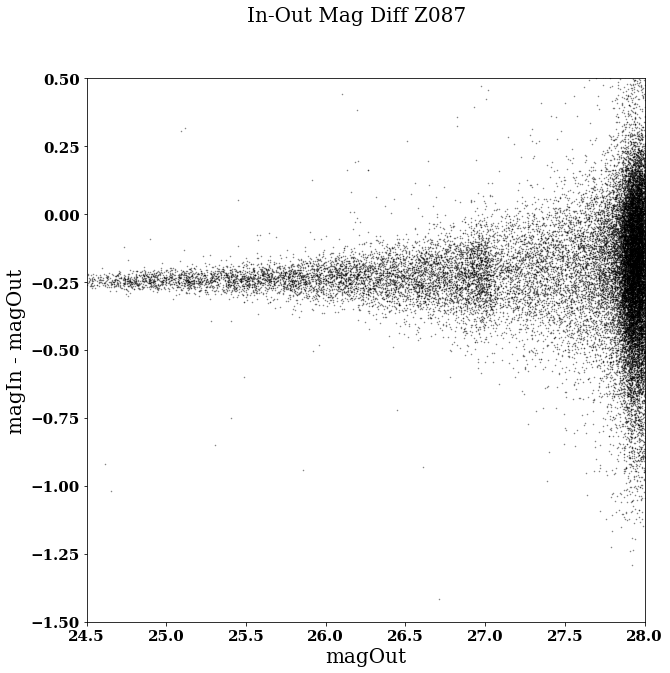

Stars: 37703  Others: 27926
			 Writing out:  output_cmd_Z087_Y106_full.png


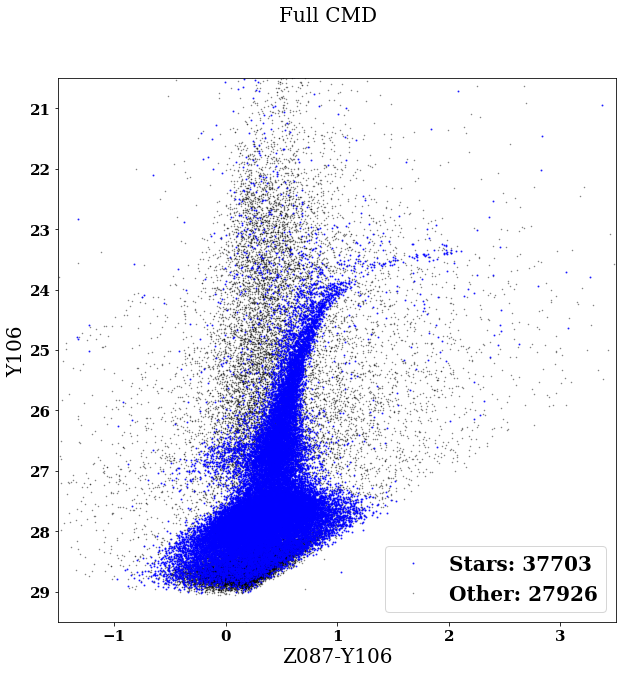

Stars: 25613  Others: 3685
			 Writing out:  clean_cmd_Z087_Y106_clean.png


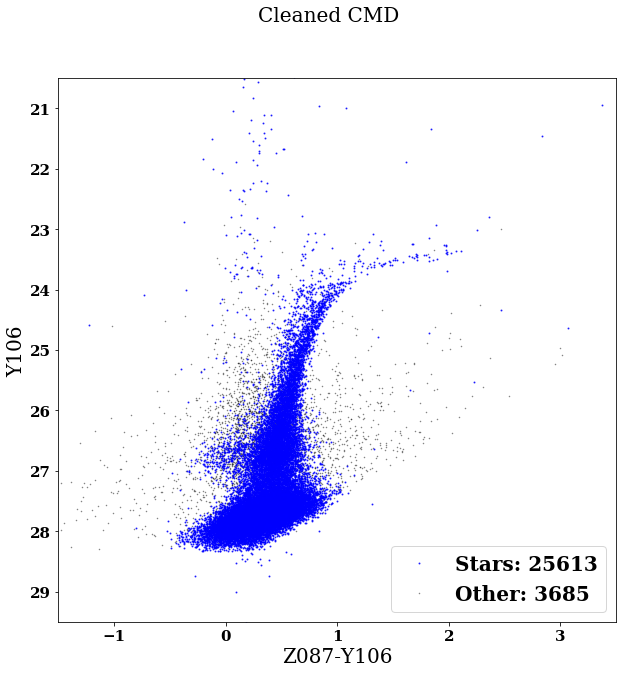

Recovery Rate:	 0.52
False Rate: 	 0.13




Filters Z087 and J129:
Stars: 49578  Others: 11304
			 Writing out:  input_cmd_Z087_J129_Vega.png


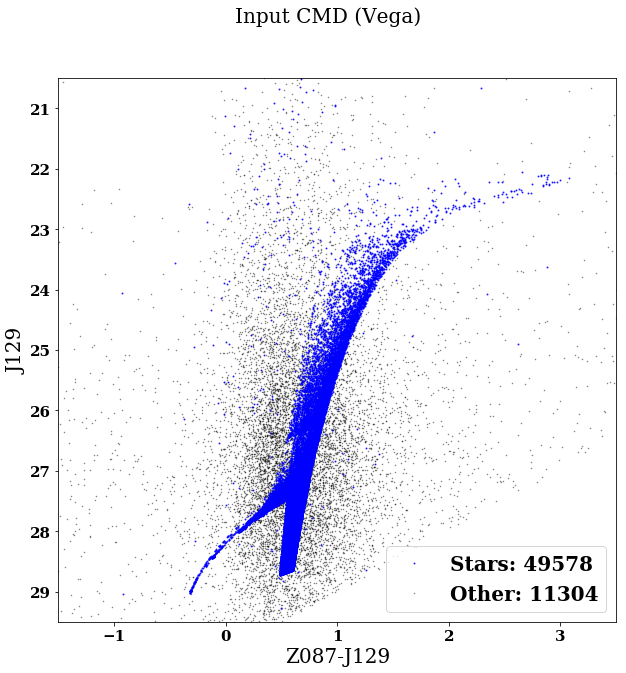

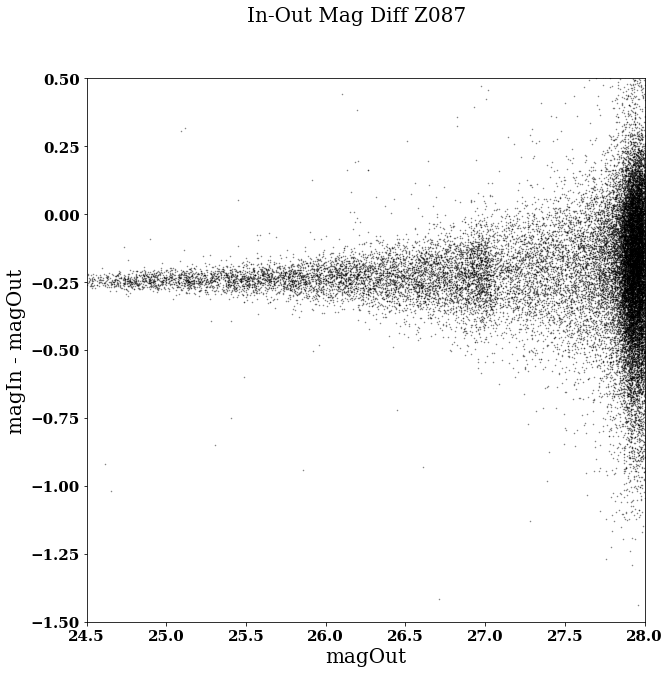

Stars: 37467  Others: 28068
			 Writing out:  output_cmd_Z087_J129_full.png


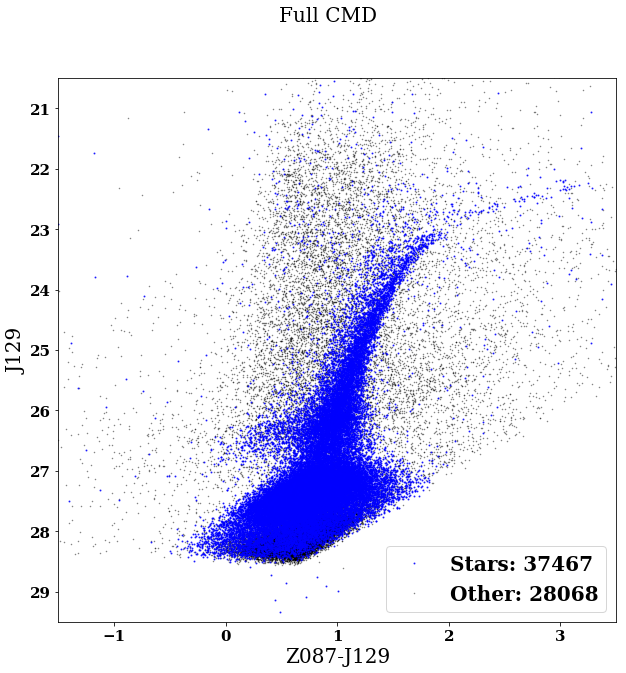

Stars: 24946  Others: 3355
			 Writing out:  clean_cmd_Z087_J129_clean.png


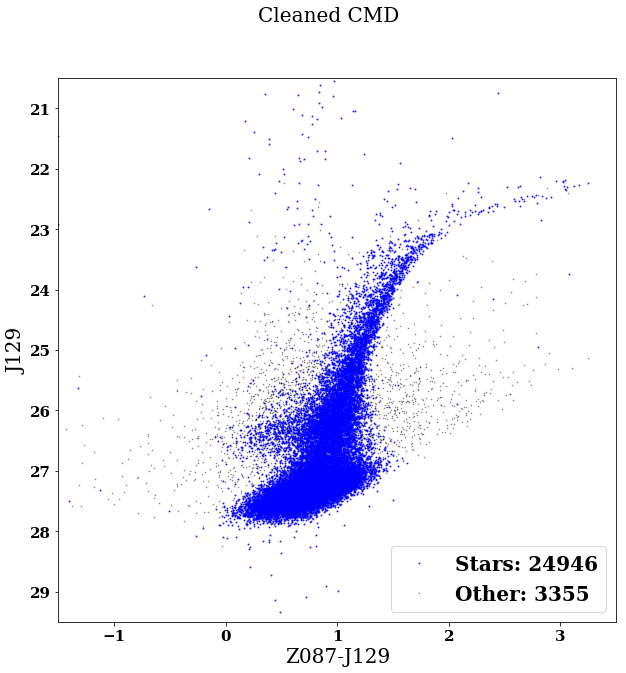

Recovery Rate:	 0.50
False Rate: 	 0.12




Filters Z087 and H158:
Stars: 49579  Others: 11320
			 Writing out:  input_cmd_Z087_H158_Vega.png


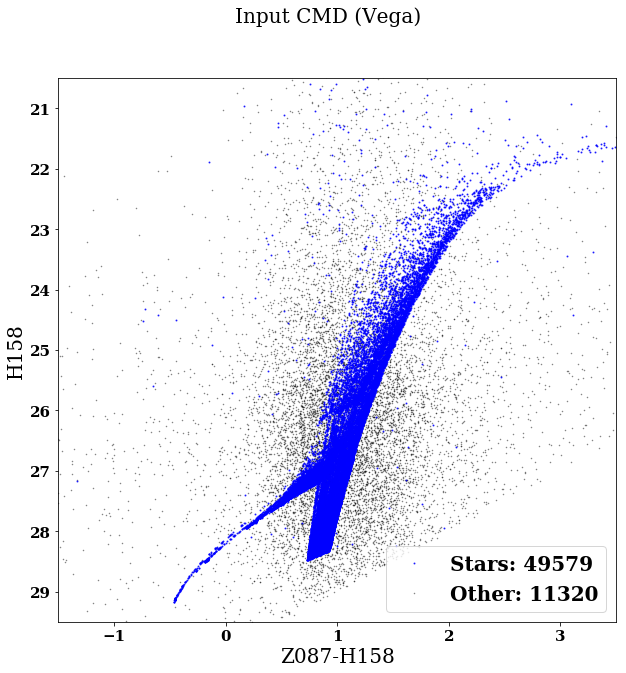

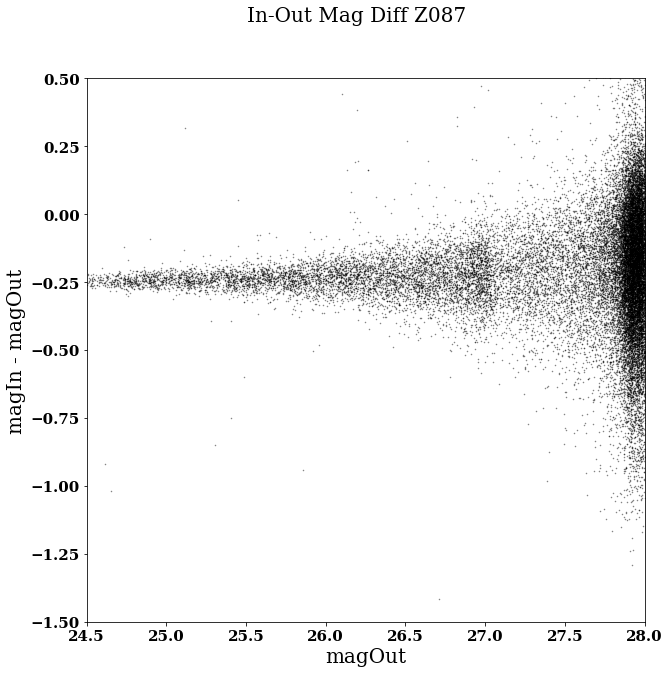

Stars: 36749  Others: 28669
			 Writing out:  output_cmd_Z087_H158_full.png


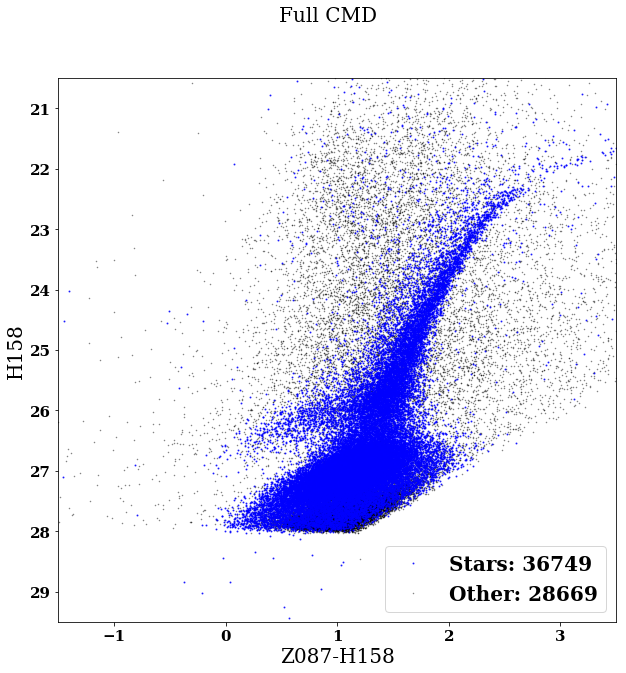

Stars: 22822  Others: 2788
			 Writing out:  clean_cmd_Z087_H158_clean.png


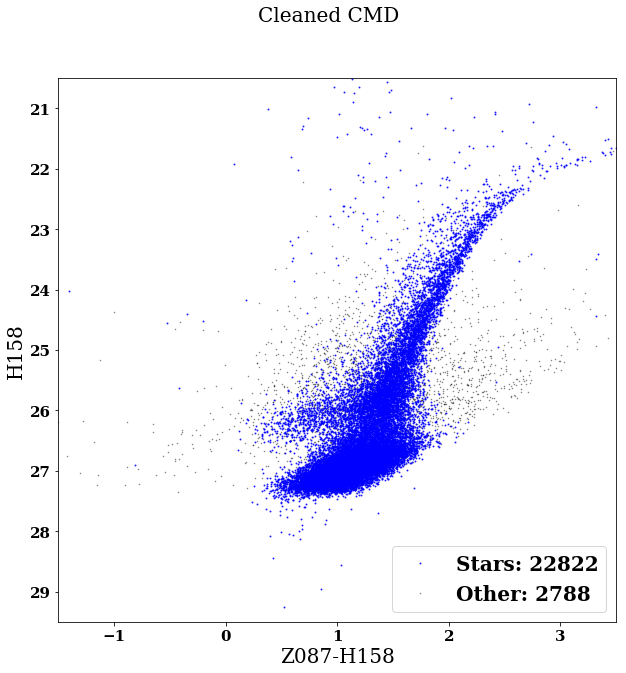

Recovery Rate:	 0.46
False Rate: 	 0.11




Filters Z087 and F184:
Stars: 49579  Others: 11341
			 Writing out:  input_cmd_Z087_F184_Vega.png


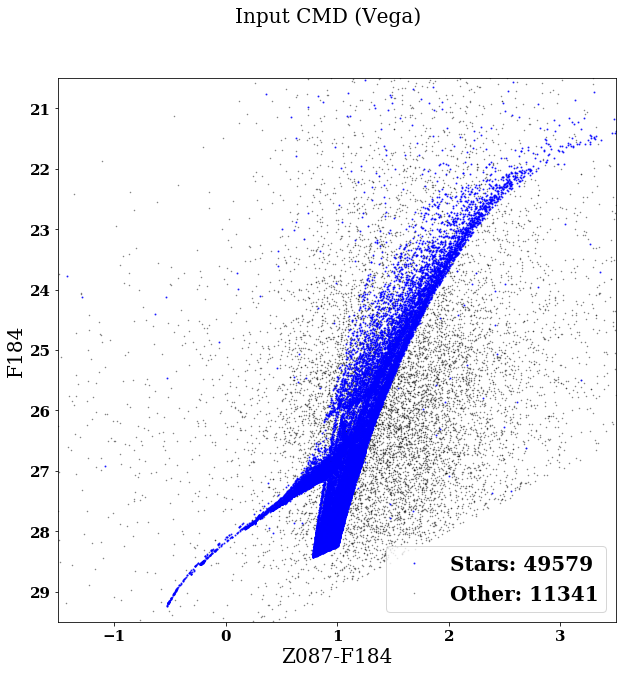

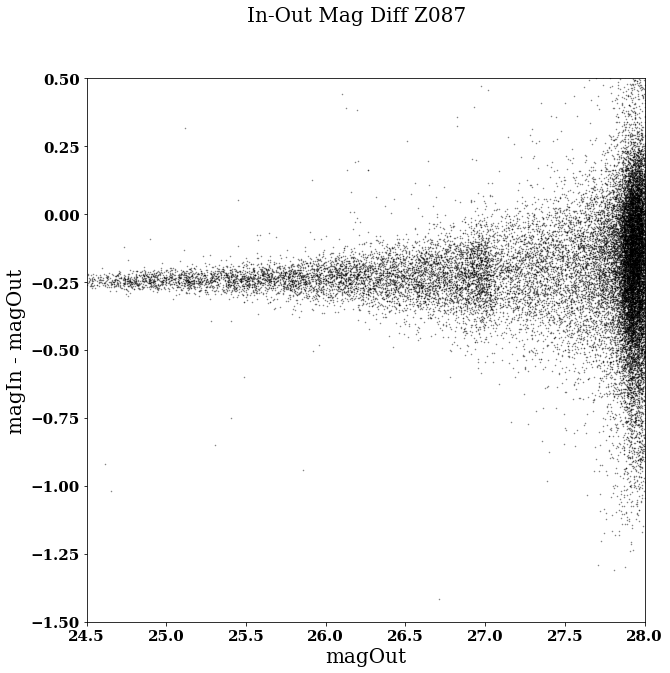

Stars: 31665  Others: 29460
			 Writing out:  output_cmd_Z087_F184_full.png


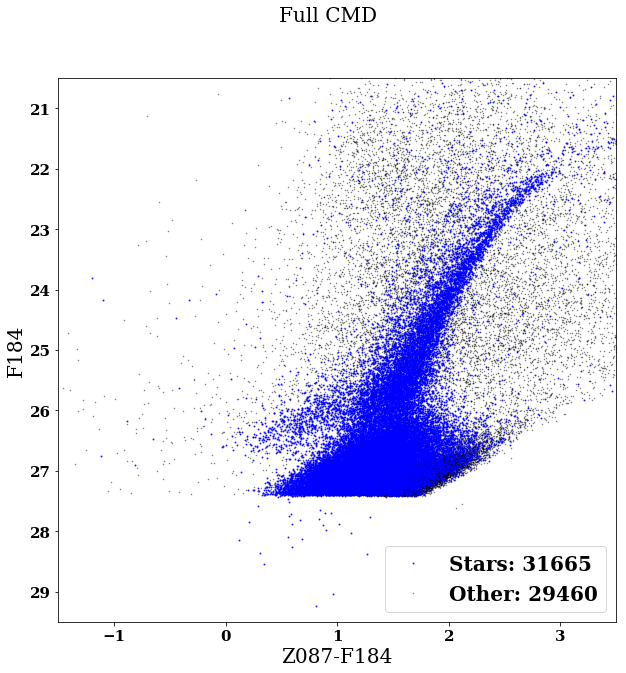

Stars: 13945  Others: 2201
			 Writing out:  clean_cmd_Z087_F184_clean.png


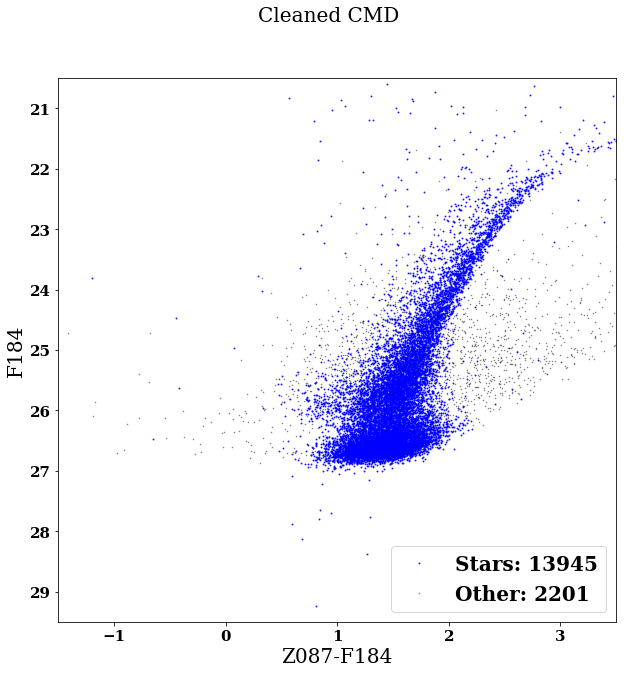

Recovery Rate:	 0.28
False Rate: 	 0.14




Filters Y106 and J129:
Stars: 49712  Others: 11724
			 Writing out:  input_cmd_Y106_J129_Vega.png


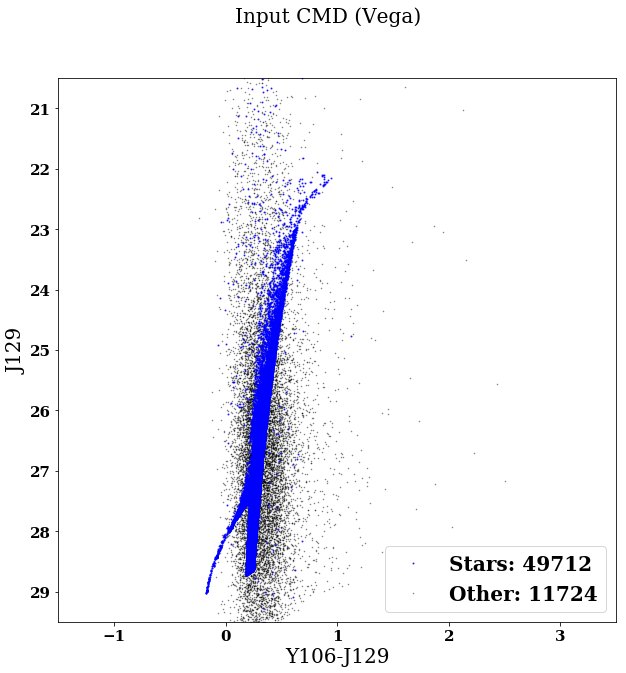

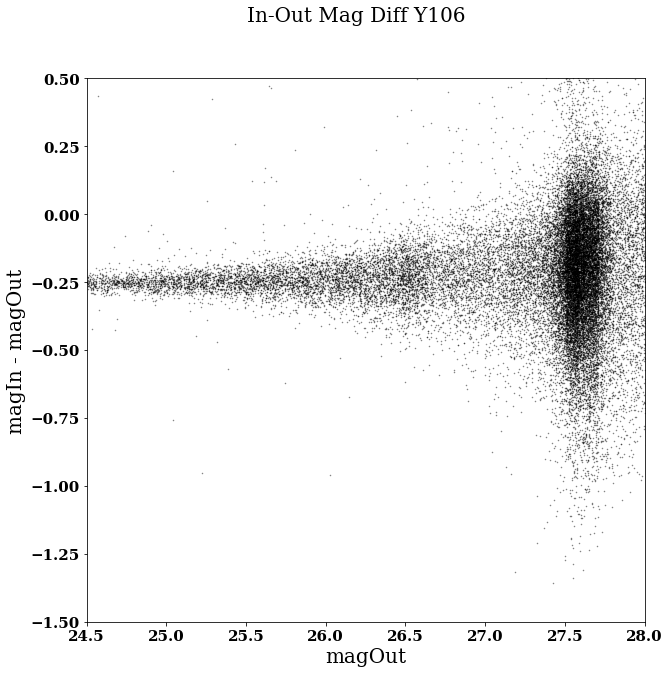

Stars: 38392  Others: 31249
			 Writing out:  output_cmd_Y106_J129_full.png


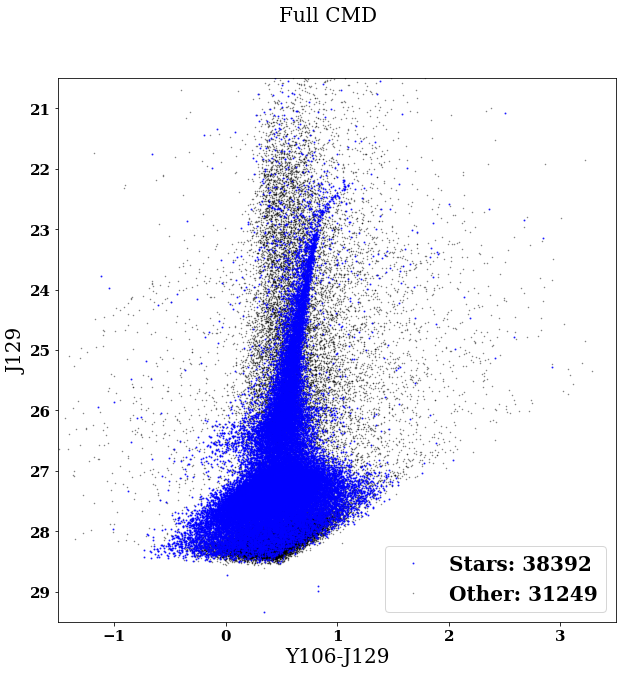

Stars: 26334  Others: 4020
			 Writing out:  clean_cmd_Y106_J129_clean.png


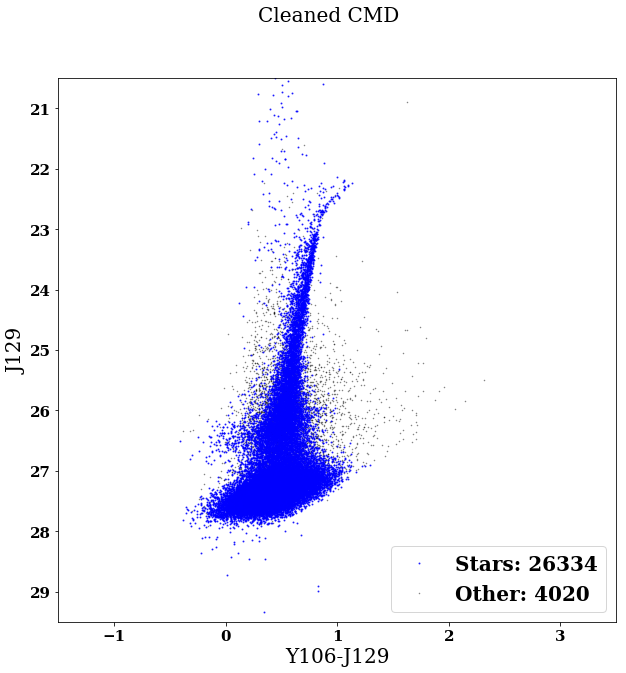

Recovery Rate:	 0.53
False Rate: 	 0.13




Filters Y106 and H158:
Stars: 49712  Others: 11633
			 Writing out:  input_cmd_Y106_H158_Vega.png


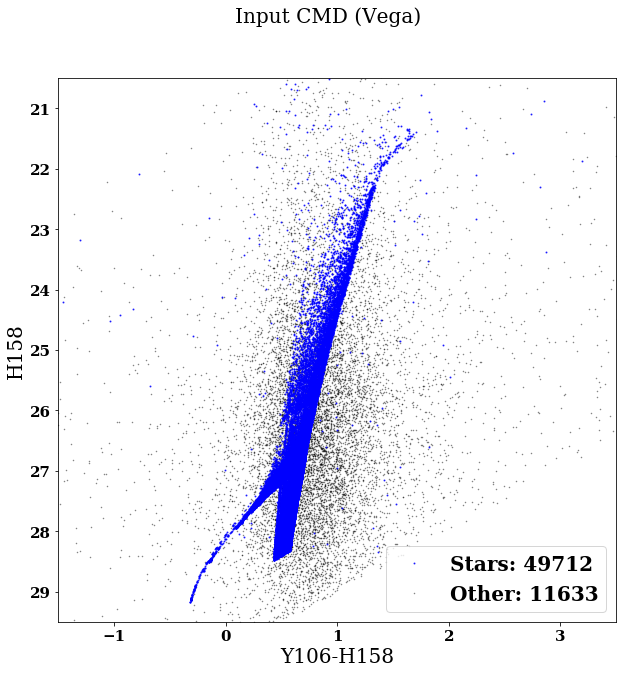

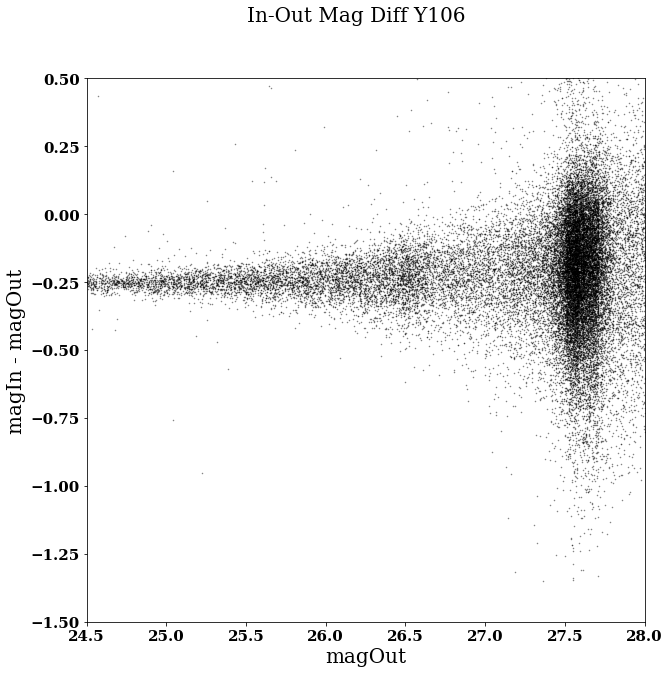

Stars: 37533  Others: 30565
			 Writing out:  output_cmd_Y106_H158_full.png


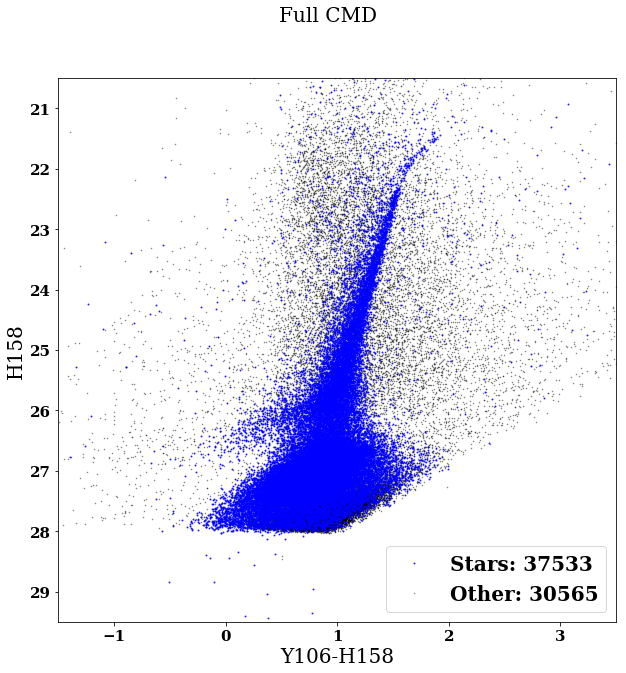

Stars: 24135  Others: 3105
			 Writing out:  clean_cmd_Y106_H158_clean.png


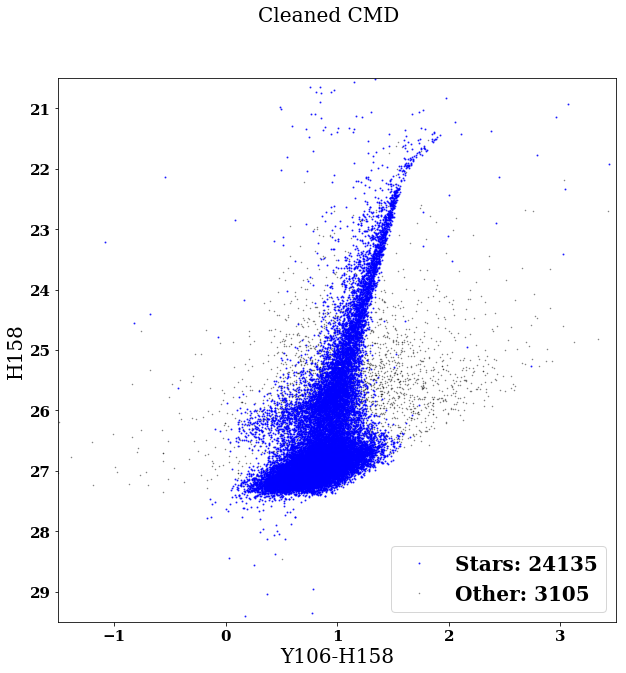

Recovery Rate:	 0.49
False Rate: 	 0.11




Filters Y106 and F184:
Stars: 49712  Others: 11648
			 Writing out:  input_cmd_Y106_F184_Vega.png


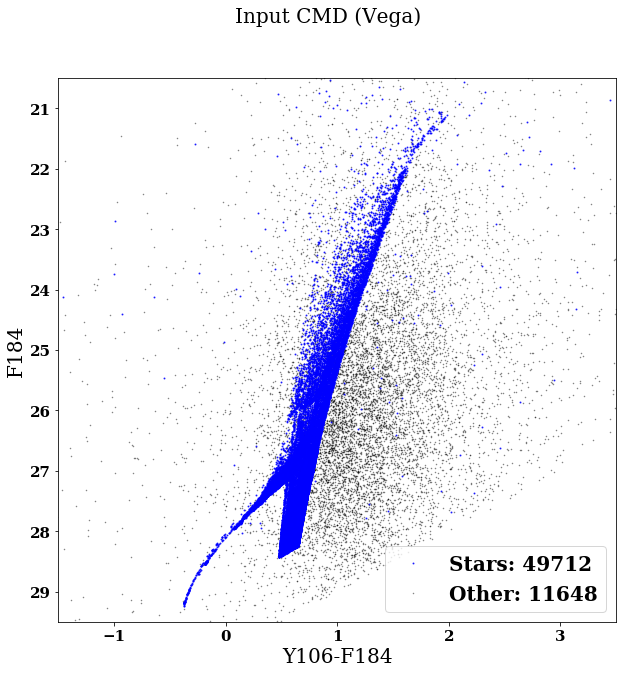

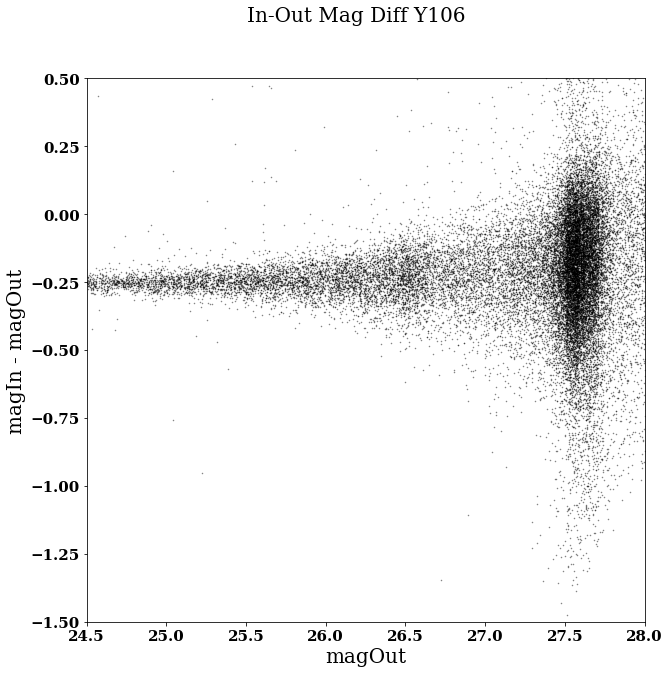

Stars: 32104  Others: 31915
			 Writing out:  output_cmd_Y106_F184_full.png


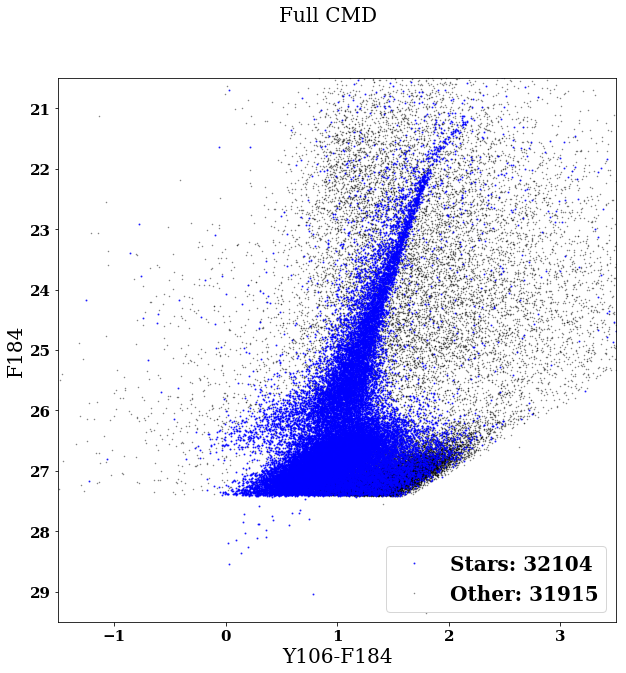

Stars: 14332  Others: 2395
			 Writing out:  clean_cmd_Y106_F184_clean.png


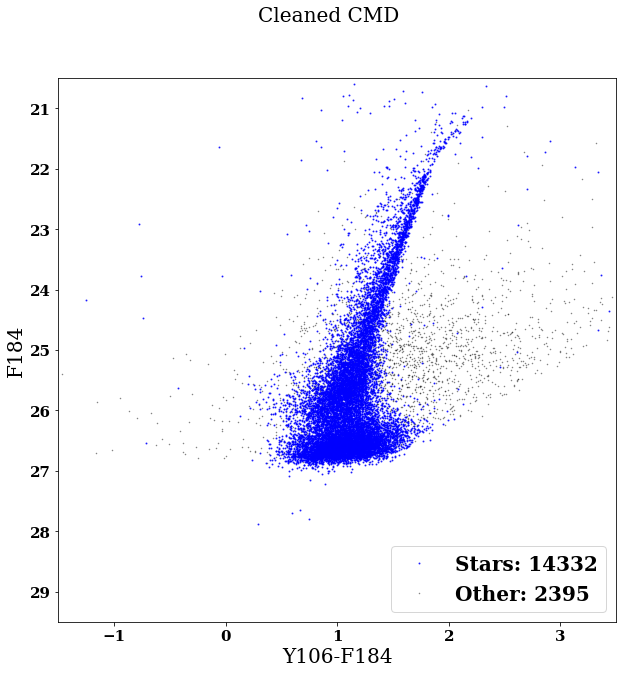

Recovery Rate:	 0.29
False Rate: 	 0.14




Filters J129 and H158:
Stars: 49902  Others: 11853
			 Writing out:  input_cmd_J129_H158_Vega.png


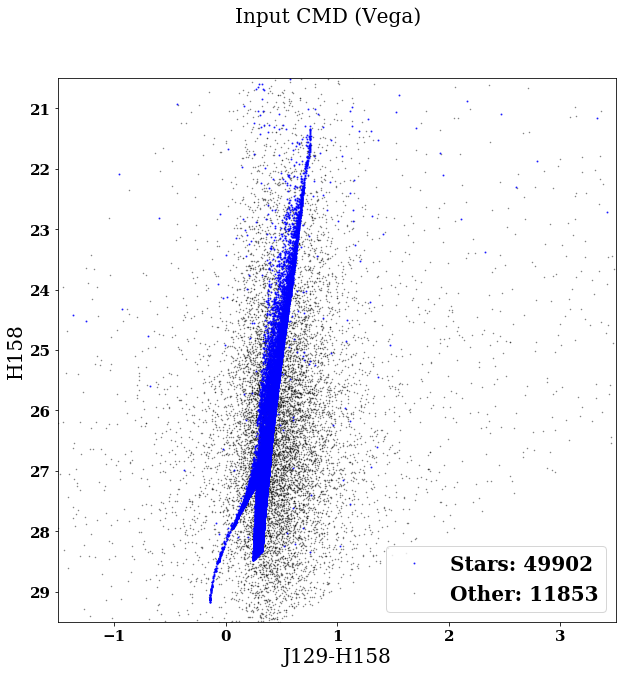

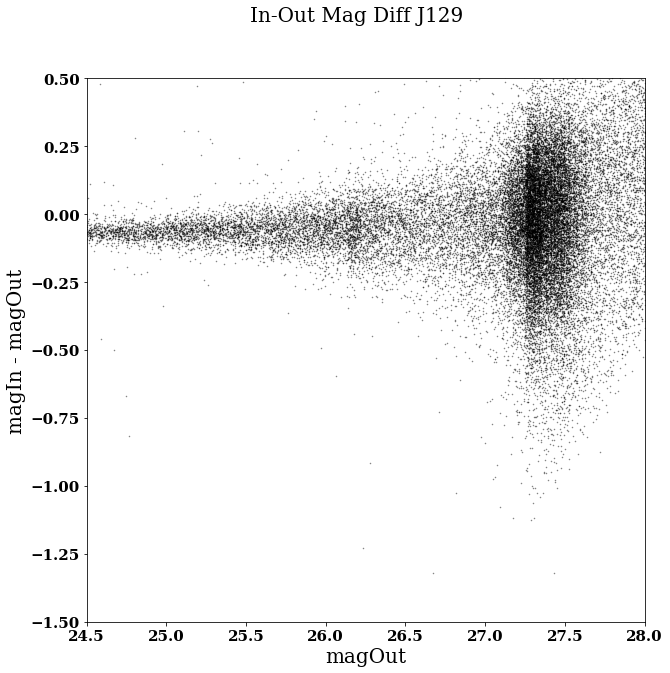

Stars: 37522  Others: 32686
			 Writing out:  output_cmd_J129_H158_full.png


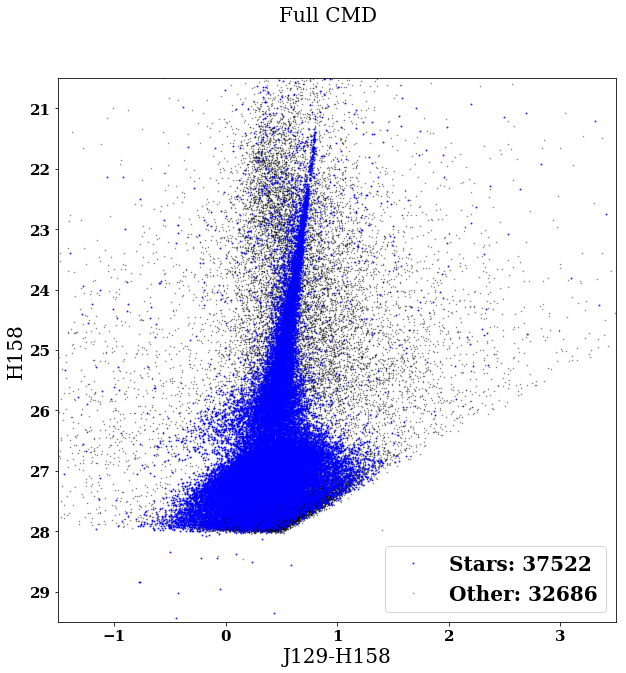

Stars: 23921  Others: 3225
			 Writing out:  clean_cmd_J129_H158_clean.png


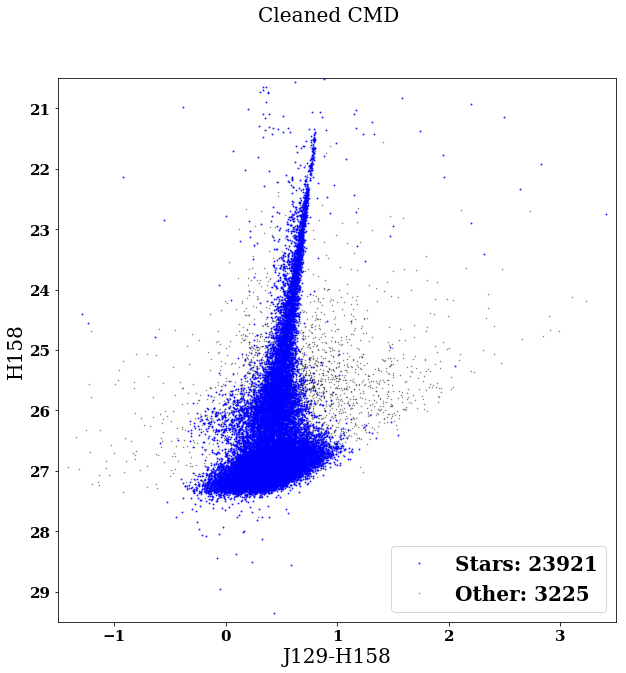

Recovery Rate:	 0.48
False Rate: 	 0.12




Filters J129 and F184:
Stars: 49902  Others: 11868
			 Writing out:  input_cmd_J129_F184_Vega.png


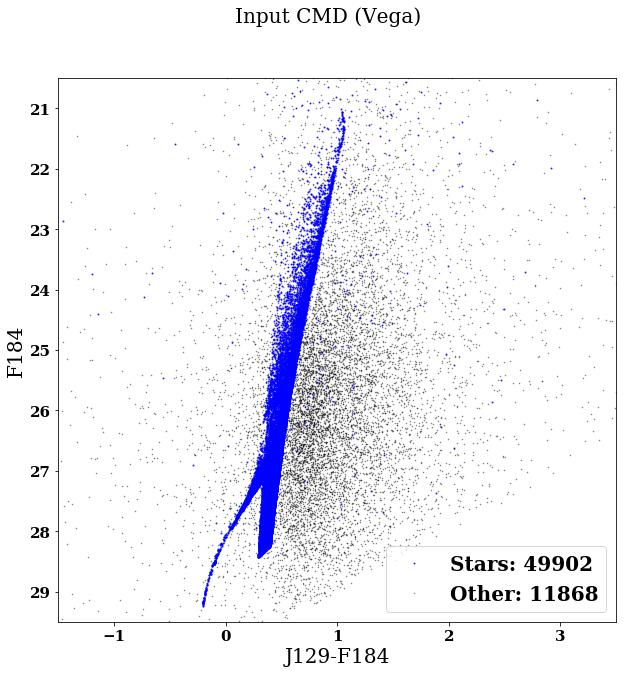

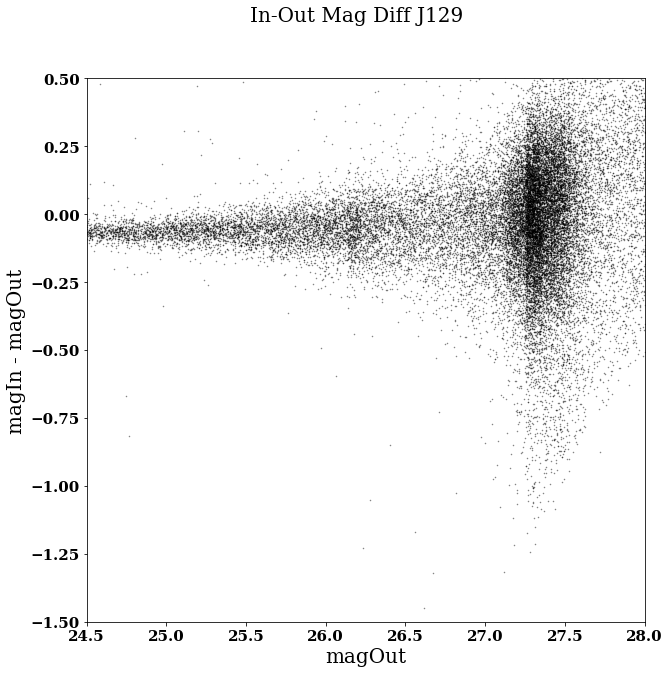

Stars: 32208  Others: 33871
			 Writing out:  output_cmd_J129_F184_full.png


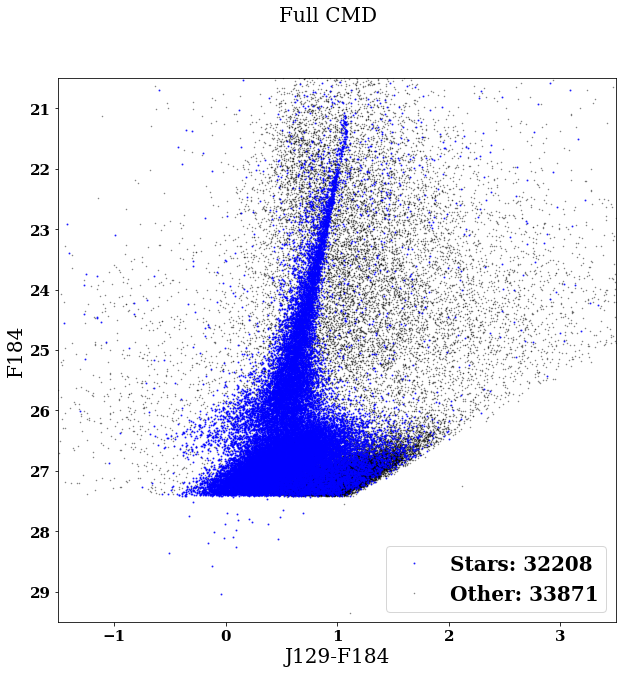

Stars: 14275  Others: 2510
			 Writing out:  clean_cmd_J129_F184_clean.png


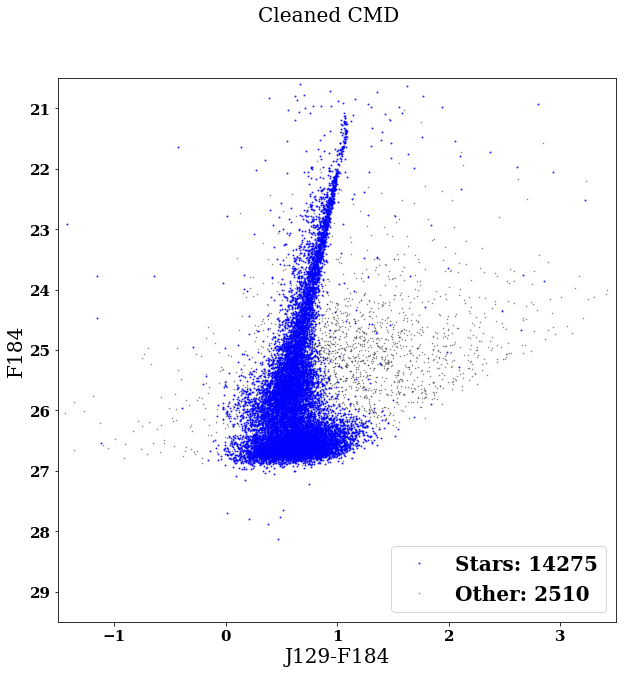

Recovery Rate:	 0.29
False Rate: 	 0.15




Filters H158 and F184:
Stars: 50088  Others: 12178
			 Writing out:  input_cmd_H158_F184_Vega.png


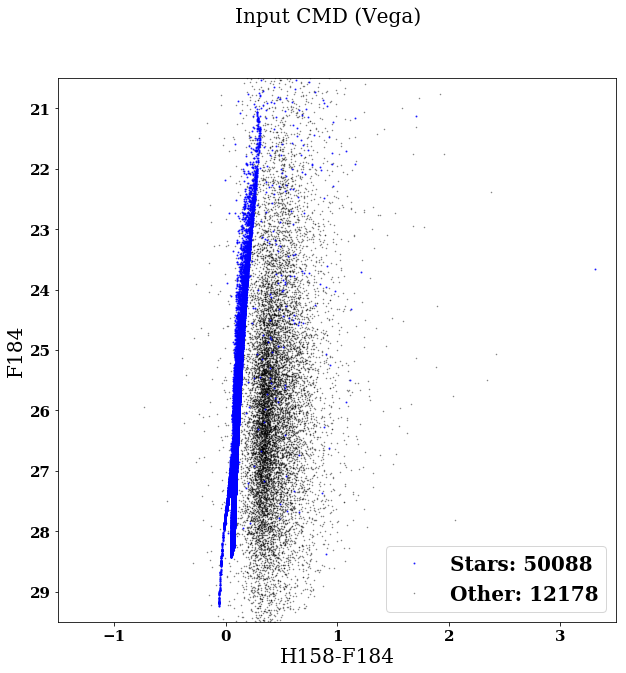

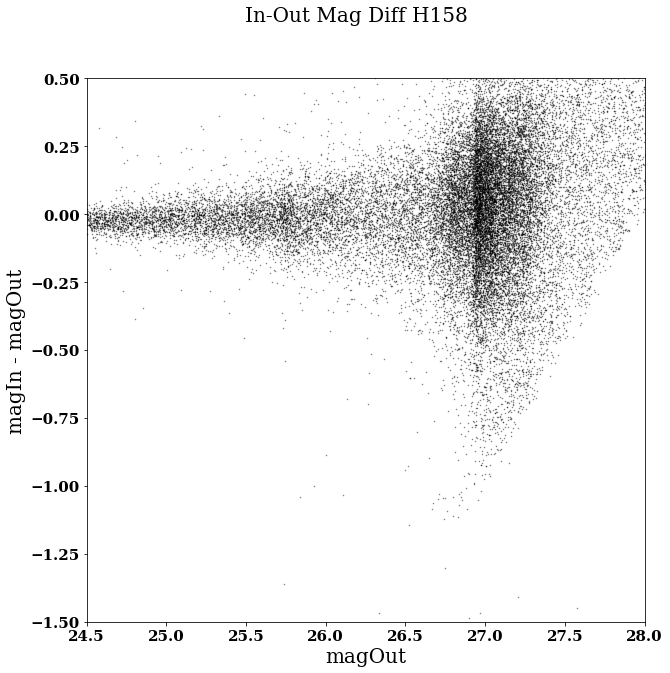

Stars: 32154  Others: 38342
			 Writing out:  output_cmd_H158_F184_full.png


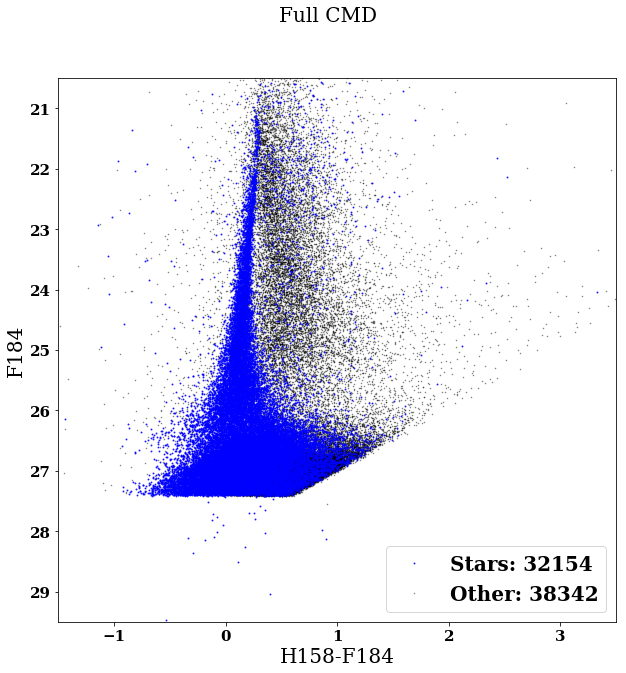

Stars: 13885  Others: 2890
			 Writing out:  clean_cmd_H158_F184_clean.png


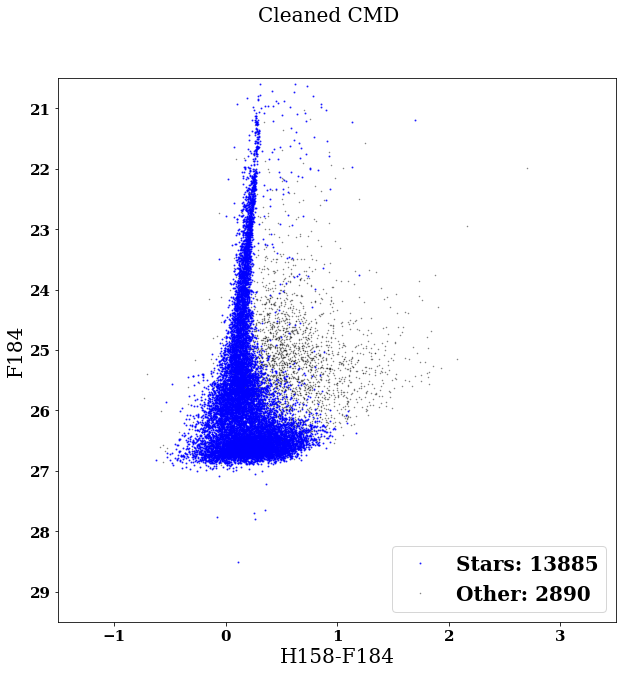

Recovery Rate:	 0.28
False Rate: 	 0.17







In [13]:
# Figures for all filter pairs
makePlots(in_DF,out_DF,new_labels,show_plot=True)

In [ ]:
clean_all()